In [98]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import netCDF4
import cmocean
import colorcet
%matplotlib inline

In [31]:
DATASETS = {
    'transect': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/jarkus/profiles/transect.nc',  # nopep8
    'BKL_TKL_TND': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/BKL_TKL_MKL/BKL_TKL_TND.nc',  # nopep8
    'DF': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/DuneFoot/DF.nc',  # nopep8
    'mkl': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/BKL_TKL_MKL/MKL.nc',  # nopep8
    'strandbreedte': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/strandbreedte/strandbreedte.nc',  # nopep8
    'strandlijnen': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/MHW_MLW/MHW_MLW.nc',  # nopep8
    'suppleties': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/suppleties/suppleties.nc',  # nopep8
    'faalkans': 'http://opendap.deltares.nl/thredds/dodsC/opendap/rijkswaterstaat/faalkans_PC-Ring/faalkans.nc'  # nopep8
}
local = True
if local:
    DATASETS['transect'] = str(pathlib.Path('../data/transect.nc'))


In [25]:
# global variables
with netCDF4.Dataset(DATASETS['transect']) as ds:
    # keep these global, for faster indexing
    ids = ds.variables['id'][:]

In [28]:
id_ = 7003900
transect_idx = np.searchsorted(ids, id_)

In [33]:
variables = {
    'lat': {"var": 'lat', "slice": np.s_[transect_idx, :]},
    'lon': {"var": 'lon', "slice": np.s_[transect_idx, :]},
    'z': {"var": 'altitude', "slice": np.s_[:, transect_idx, :]},
    "t": {"var": 'time', "slice": np.s_[:]}

}
data = {}

with netCDF4.Dataset(DATASETS['transect']) as ds:
    for var, props in variables.items():
        data[var] = ds.variables[props['var']][props['slice']]
    time_units = ds.variables['time'].units

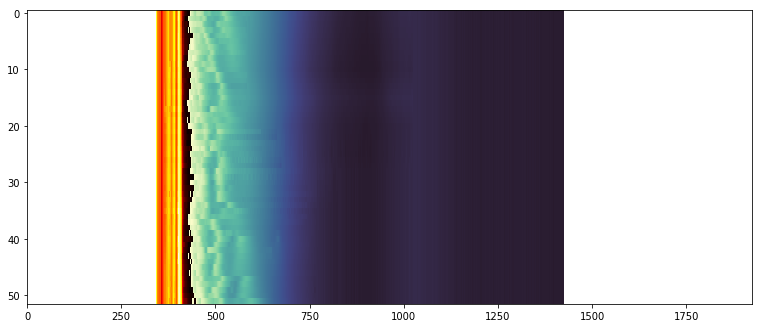

In [108]:
import scipy.interpolate
def fill(z):
    """fill z by space and then time"""
    def fill_space(z):
        """fill space"""
        x = np.arange(z.shape[0])
        F = scipy.interpolate.interp1d(x[~z.mask], z[~z.mask], bounds_error=False)
        z_interp = F(x)
        z_filled = np.ma.masked_invalid(z_interp)
        return z_filled
    def fill_time(z):
        """fill time"""
        z_filled = np.ma.masked_all_like(z)
        for i in range(z.shape[1]):
            arr = z[:, i]
            # if there's no data, continue
            if arr.mask.all():
                continue
            # interpolate in time
            xp = np.arange(len(arr))
            z_filled[:, i] = scipy.interp(xp, xp[~arr.mask], arr[~arr.mask])
        return z_filled

    filled_z = np.ma.apply_along_axis(fill_space, 1, data['z'])
    filled_z = fill_time(filled_z)
    return filled_z

    

fig, ax = plt.subplots(figsize=(13, 8))
filled_z = fill(data['z'])
ax.imshow(np.ma.masked_greater(filled_z, 0), aspect=15, cmap=cmocean.cm.deep_r)
ax.imshow(np.ma.masked_less_equal(filled_z, 0), aspect=15, cmap='hot')

In [115]:
b = cmocean.cm.deep._segmentdata['blue'][0][1]
r = cmocean.cm.deep._segmentdata['red'][0][1]
g = cmocean.cm.deep._segmentdata['green'][0][1]

In [116]:
r, g, b

(0.99283717653836201, 0.99437345530139354, 0.80013619554949333)